# Straka Bubble Test 🫧

<div class="alert alert-block alert-success">

## Part 1: Problem Set Up + Ideal Gas Law Review

Welcome to the first $\texttt{PADDLE}$ tutorial! In this set of tutorials, we will demonstrate how to initialize and run the code for dynamical simulations, and processing outputs, by showcasing the Straka bubble test. 
 
The Straka bubble test, developed by [Straka et al. (1993)](https://onlinelibrary.wiley.com/doi/abs/10.1002/fld.1650170103), is a standard benchmark test of non-hydrostatic numerical models. 

The test involves simulating a dense, sinking bubble that collides with a bottom, rigid, boundary layer. The full execution of the code follows the sinking of the bubble, and the resulting density currents/perturbations at the boundary layer. 

The sinking bubble is a perfect introduction for how a non-hydrostatic code, like $\texttt{PADDLE}$, differs from codes that assume hydrostatic equilibrium. In particular, hydrostatic equilibrium assumes that the vertical pressure gradient balances gravity.

In the sinking bubble case, there is a density perturbation that causes it to break this equilibrium, since it must accelerate and sink. Processes similar to the sinking bubble case occur in planetary atmospheres, where parcels of air can differ in density or temperature from their surrounding environment, causing non-hydrostatic convective motions. 

This test was first applied to $\texttt{SNAP}$ (Simulating Nonhydrostatic Atmospheres on Planets, the underlying numerical simulation solver of $\texttt{PADDLE}$) in [Li et al. (2019)](https://iopscience.iop.org/article/10.3847/1538-4365/aafdaa). It was also applied to $\texttt{CANOE}$ (Comprehensive Atmosphere N' Ocean Engine, another underlying code to $\texttt{PADDLE}$), see this [blog post](https://public.websites.umich.edu/~jihenghu/space/research/canoe-athena/canoe-example-straka/index.html).

Let's get started by setting up the Straka problem and reviewing properties of ideal gases!
</div>

<img src="../../images/2d.straka-theta.png">

<div class="alert alert-info">

## The Problem

In simple terms, the Straka problem involves: 

1. A background 2-dimensional, **ideal-gas** atmosphere that has a constant **potential temperature** of 300K (referenced at 1 bar).

2. A parcel of gas (a bubble) is defined, vertically displaced, with a maximum temperature difference of -15K. 

Where we additionally assume that the process is **adiabatic**.

In $\texttt{PADDLE}$, we must find a way to define the initial problem as described above with **primitive variables**.

</div>


<div class="alert alert-warning">

$\textbf{Definition: Potential Temperature}$ ($\theta$)  is the temperature a parcel of unsaturated (no moisture, also known as 'dry') air in the atmosphere would have if it is moved **adiabatically** (not losing or gaining any heat to the environment) to a specific pressure. 

In this case, it means that a parcel of dry air in the background atmosphere would have a temperature of 300K at 1 bar (which is, coincidentally, the temperature and surface pressure of Earth). It is defined for an ideal gas as 

$$\theta = T(\frac{P_0}{P})^{\frac{R}{c_p}}$$

where $T$ is the temperature of the parcel, $P$ is the pressure of the parcel, $P_0$ is the reference pressure (here, 1 bar), $R$ is the specific gas constant of air, and $c_p$ is the specific heat capacity at constant pressure. In our background atmosphere, if a parcel of dry air is brought adiabatically from a pressure $P$ and temperature $T$ to 1 bar, it would be 300K. 

Potential Temperature is a hugely important quantity in dynamical simulations, since it is a conserved quantity for dry adiabatic processes and is useful in determining the atmospheric stability of a parcel of gas.

In particular, if the potential temperature increases with height the atmosphere is stable (vertical motions of parcels are suppressed, i.e., stably stratified) and if it decreases with height the atmosphere is unstable and prone to convection (perturbed air parcels with either rise or sink).

</div>

<div class="alert alert-warning">

$\textbf{Definition: Primitive Variables}$

In compressible hydrodynamic simulations, **primitive variables** are fundamental physical quantities used to solve the state of the system via the primitive equations (the equations that approximate atmospheric flows). 

The five primitive variables used in $\texttt{PADDLE}$ are: $\textbf{density}$, $\textbf{velocity}$ (one for each dimension), and $\textbf{pressure}$. These variables are set by the user as the initial condition of a simulation.

$\textbf{Definition: Conserved Variables}$

**Conserved variables** are variables that remain constant (at each time step of the simulation) when an integral of the entire simulation domain is taken. These include $\textbf{momentum}$, $\textbf{energy}$, and $\textbf{mass}$. These variables are not set by the user. 

$\textbf{Definition: Diagnostic Variables}$

**Diagnostic variables** are variables that are not used explicitly by the dynamical simulation, but can be computed from either the **primitive** or **conserved variables**. 

The most common are $\textbf{temperature}$ and $\textbf{potential temperature}$.

</div>

So the first step is to figure out how to set up our initial condition of the bubble in terms of primitive variables. Luckily, there are many properties of an ideal gas that will help us out. 

<div class="alert alert-info">

## Ideal Gas Properties

For our bubble test, we will assume that the entire atmosphere is an ideal gas. 

This is useful, since for an ideal gas with a constant heat capacity, there is an analytic solution for density and pressure (two of our **primitive variables**).

<div class="alert alert-warning">

Here we review some fundamentals of the ideal gas law. For our purposes, an ideal gas can have all of their state variables (pressure, temperature, etc.) defined entirely by two variables: 

1. **The adiabatic index $\gamma$**

The adiabatic index is 

$\gamma = \frac{c_p}{c_v} = \frac{C_P}{C_V}$

where c is the heat capacity at either constant pressure (cp) or constant volume (cv). The lowercase c is the specific heat capacity (which depends on mass, units $J/K\cdot kg$ = $(kg \cdot m^2/s^2)/K\cdot kg$) while the uppercase C is just the heat capacity (units $J/K$). 

The adiabatic index is 1.66 for monoatomic gases (He, Ar) and 1.4 for diatomic gases (N2, O2, Air)

2. **Molecular weight $M$**

The molecular weight is given by $kg/mol$. For Earth, it is 29.3e-3 kg/mol. 

</div>

There are some useful equations we will make use of to relate our state problem (which is in terms of temperature) to one of density and pressure. 

<div class="alert alert-warning">

$\textbf{Ideal Gas Law:} \; P = \frac{\rho R T}{M} = \rho R_d T$

where P is pressure, $\rho$ is density, R is the ideal gas constant, T is temperature, and M is molecular weight. Often times, we will define a specific gas constant $R_d$ which is equal to R/M. This equation is known as the **equation of state** of the atmosphere.

We can also define the following for the specific heat capacities: 

$c_v = \frac{R_d}{\gamma - 1}$

and 

$c_p = \frac{\gamma R_d}{\gamma-1} = c_v + R_d$

</div>

In [1]:
# Lets define the two properties needed for an ideal gas 

# gammad is the adiabatic index
# 1.4 for diatomic gasses (N, O, Air)
gammad = 1.4 

# molecular weight (kg/mol)
# This is the molecular weight of Earth's atmosphere 
weight = 29.3e-3 # in kg/mol

<div class="alert alert-info">

## Setting Up the Initial Problem Conditions

Now lets figure out how to set up the actual properties of the bubble in the simulation, and the atmosphere surrounding it. 

In order to do this, we have to get a bit creative and find a mathematical way to define the bubble's initial conditions. 

The bubble itself is defined by its spatial dimensions and temperature distribution. 

</div>

#### Bubble's spatial intialization

Lets define an elliptical-shaped bubble whose center is at the coordinate (0 km, 3 km), where will take 0 is the width coordinate, and 3 is the height coordinate.

**In $\texttt{PADDLE}$, height is often defined as the first dimension (x1, *z*) and while width is the second dimension (x2, *x*), so the coordinate is better described as (3 km, 0 km)**

For its size, lets define the bubble to extend 4 km right and left of the center (total width of 8 km), and 2 km up and down of the center (total height 4 km).

<div class="alert alert-warning">

By definition, the bubble will exist wherever the elliptical distance (*L*) is less than 1, where 

$L = ((\frac{x-x_c}{x_r})^2+(\frac{z-z_c}{z_r})^2)^{1/2}$

where *x_c* and *z_c* are the center coordinate of the bubble, and *x_r* and *z_r* are the maximum left/right up/down distance from the bubble's center.

</div>

Lets plot what this looks like in practice.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Lets first define our simulation grid space 
# This portion will be more clearly defined in Straka Part 2
# But in PADDLE, we have to define both
# spatial dimensions (bounds)
# spatial resolution (cells)

# Here we define a simulation that is 64 km high and 256 km wide
# with one cell per km

# x1 = Height (often denoted with 'z')
x1min = 0
x1max = 6.4e3 # in meters

# nx1 = Number of Cells in Height Dimension
nx1 = 64 # 1 cell per 0.1 km 

# x2 = Width (often denoted with 'x')
x2min = 0
x2max = 25.6e3 # in meters

# nx2 = Number of Cells in Width Dimension 
nx2 = 256 # 1 cell per 0.1 km 

Text(0, 0.5, 'Simulation Vertical Extent (km, x1, z)')

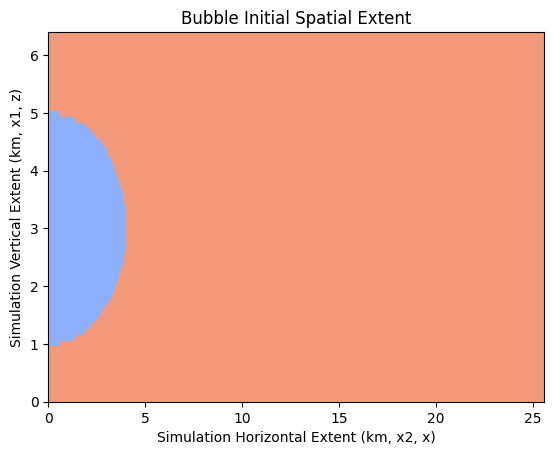

In [4]:
# Center of the bubble is at 0, 3 km

zc = 3e3 # height of center, in meters
xc = 0   # left/right of center, in meters

# Maximum distance up/down,left/right,  from center of bubble 

zr = 2e3 # up/down from center, in meters
xr = 4e3 # left/right from center, in meters

# Lets plot the bubble's spatial extent 

# Simulation domain as defined in cell above
# Note that x1 (z) is height 
# and that x2  (x) is width 
z_array = np.linspace(x1min, x1max, nx1)
x_array = np.linspace(x2min, x2max, nx2)

# Create meshgrid in order to plot 
Z, X = np.meshgrid(z_array, x_array)

# Elliptical distance, as defined above
L = ((((X-xc)/xr)**2) + (((Z-zc)/zr)**2))**0.5

# Add the mask L < 1 (which defines the spatial extent of the bubble)
# Divide X and Z by 1000 to get km instead of m 
plt.contourf(X/1000,Z/1000, L < 1, cmap = 'coolwarm_r')
plt.title('Bubble Initial Spatial Extent')
plt.xlabel('Simulation Horizontal Extent (km, x2, x)')
plt.ylabel('Simulation Vertical Extent (km, x1, z)')

#### Bubble's temperature anomaly initialization

We will then want to define some sort of temperature distribution so that the maximum temperature difference of the bubble will be -15K of the surrounding atmosphere. 

<div class="alert alert-warning">

The following definition ensures there is a sort of gradient of temperature anomaly: 

$\Delta T = -15K \; \frac{\mathrm{cos}(\pi L) + 1}{2} \; ; \; L < 1$

The temperature difference between the bubble and its surrounding atmosphere, $\Delta T$, is known as the temperature anomaly. 

</div>

Lets plot what this looks like: 

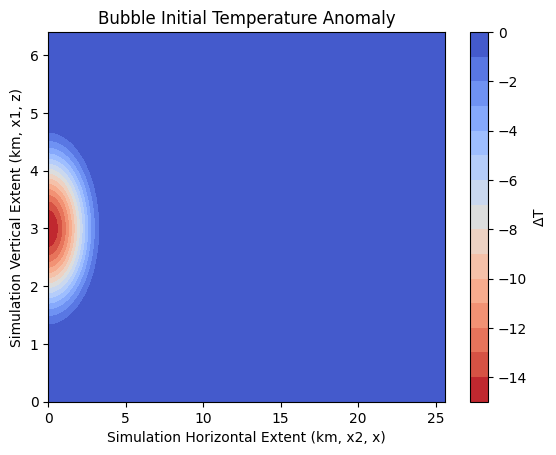

In [5]:
# Maximum temperature difference from surrounding atmosphere
dT = -15 # in Kelvin 

# Temperature anomaly 
# Where L<1 (within bounds of bubble) compute delta_T, otherwise, delta_T = 0
delta_T = np.where(L < 1, dT*((np.cos(np.pi*L) + 1)/2), 0)

# Plot with delta_T as colormap 
plt.contourf(X/1000,Z/1000, delta_T, cmap = 'coolwarm_r', levels = np.linspace(-15,0,16))
plt.title(r'Bubble Initial Temperature Anomaly')
plt.xlabel('Simulation Horizontal Extent (km, x2, x)')
plt.ylabel('Simulation Vertical Extent (km, x1, z)')
plt.colorbar(label = r'$\Delta$T')

#### Deriving initial temperature, pressure, and density of entire simulation domain

Since we defined the background atmosphere as an ideal gas, the simulation as adiabatic, and we know a specific pressure-temperature point (1 bar = 300K), we can derive the full initial condition of the atmosphere (for more complex atmospheres, $\texttt{PADDLE}$ can compute initial conditions, which we will explore in future tutorials).

<div class="alert alert-warning">
The dry adiabatic lapse rate (i.e., how temperature changes with altitude) for an ideal gas is 

$\frac{dT}{dz} = -\frac{g}{c_p}$ 
</div>

where *g* is gravity, and the units are

$\frac{K}{m} = \frac{m/s^2}{J/K\cdot kg} = \frac{m/s^2}{(kg \cdot m^2/s^2)/K\cdot kg}$

We can derive $c_p$ using the equation above.

In [6]:
# Gravity (Earth's gravity)
gravity = 9.8

In [7]:
# Thermodynamic constants 

# Specific gas constant
Rd = (8.314/weight)

# Specific heat capacity at constant volume 
cv = Rd/(gammad-1)

# Specific heat capacity at constant pressure 
cp = cv + Rd

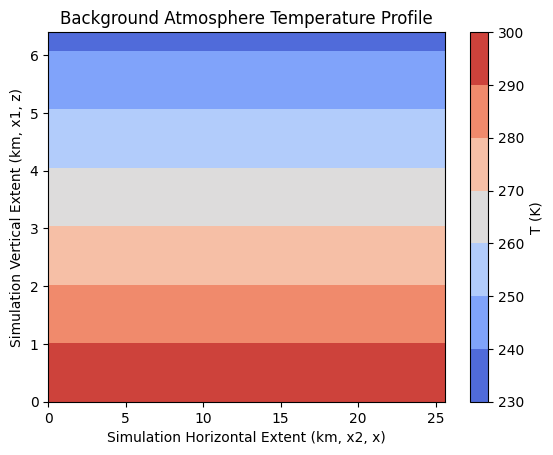

In [8]:
# Dry adiabatic lapse rate for ideal gas
dT_dz = -gravity/cp # K per m 

# Surface temperature is 300K 
# As defined in the problem statement above
Ts = 300

# Ps is the surface pressure
# 1 bar = 1e5 pascals 
# We'll need this later!
Ps = 1e5

# T = Initial Temperature + (lapse rate * altitude array)
T_array = 300 + (dT_dz*Z)

# Plot temperature w/ height 
plt.contourf(X/1000,Z/1000, T_array, cmap = 'coolwarm', levels = np.linspace(230,300,8))
plt.title(r'Background Atmosphere Temperature Profile')
plt.xlabel('Simulation Horizontal Extent (km, x2, x)')
plt.ylabel('Simulation Vertical Extent (km, x1, z)')
plt.colorbar(label = r'T (K)')

We can now apply the temperature anomaly of the bubble to the atmosphere

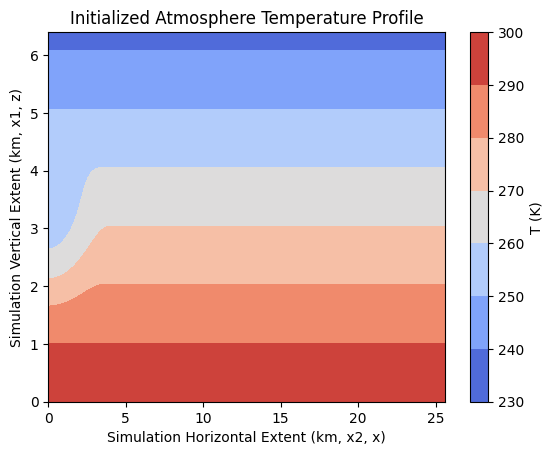

In [9]:
# Temperature array + temperature anomaly array 
plt.contourf(X/1000,Z/1000, T_array + delta_T, cmap = 'coolwarm', levels = np.linspace(230,300,8))
plt.title(r'Initialized Atmosphere Temperature Profile')
plt.xlabel('Simulation Horizontal Extent (km, x2, x)')
plt.ylabel('Simulation Vertical Extent (km, x1, z)')
plt.colorbar(label = r'T (K)')

<div class="alert alert-info">

## Setting Up the Initial Problem Conditions w/ Primitive Variables

Now that we've set up the problem in both space and temperature, lets figure out how to turn it into an initial condition in terms of **primitive variables**.

Lets first set up the pressure **before** we apply the temperature anomaly of the bubble. 

We can do this, since pressure equilibrates at the speed of sound (so pressure inside the bubble is the same as pressure outside the bubble).

The pressure of our atmosphere is given by 

<div class="alert alert-warning">

$P = P_s (\frac{T}{T_s})^\frac{c_p}{R_d}$

where $P_s$ and $T_s$ is the surface pressure and temperature.

</div>


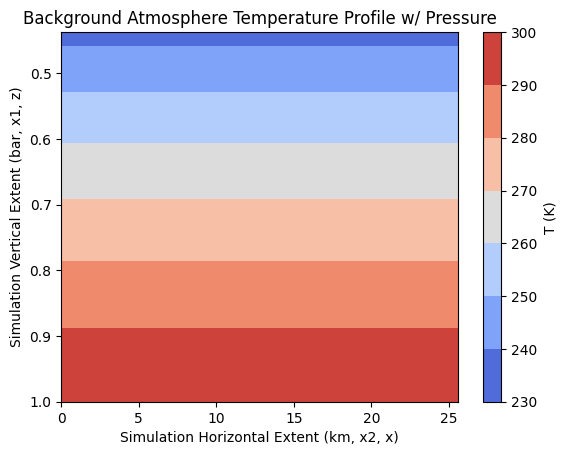

In [10]:
P = Ps*((T_array/Ts)**(cp/Rd))

# Plot pressure in bars on y-axis
plt.contourf(X/1000,P/1e5, T_array, cmap = 'coolwarm',levels = np.linspace(230,300,8))
plt.gca().invert_yaxis()
plt.title(r'Background Atmosphere Temperature Profile w/ Pressure')
plt.xlabel('Simulation Horizontal Extent (km, x2, x)')
plt.ylabel('Simulation Vertical Extent (bar, x1, z)')
plt.colorbar(label = r'T (K)')

We can now apply the temperature anomaly to the atmosphere: 

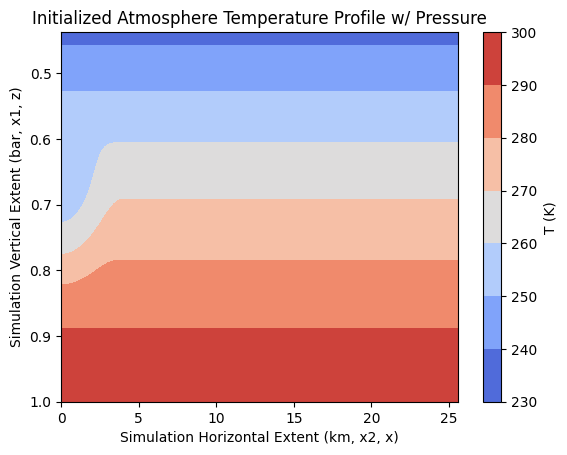

In [11]:
P = Ps*((T_array/Ts)**(cp/Rd))
# Note, we still keep Pressure initialized without the temperature anomaly! 

# Plot pressure in bars on y-axis
plt.contourf(X/1000,P/1e5, T_array+delta_T, cmap = 'coolwarm',levels = np.linspace(230,300,8))
plt.gca().invert_yaxis()
plt.title(r'Initialized Atmosphere Temperature Profile w/ Pressure')
plt.xlabel('Simulation Horizontal Extent (km, x2, x)')
plt.ylabel('Simulation Vertical Extent (bar, x1, z)')
plt.colorbar(label = r'T (K)')

After applying the temperature anomaly, we can get the initial density using the ideal gas law: 

<div class="alert alert-warning">

$\rho = \frac{P}{R_d T}$

</div>

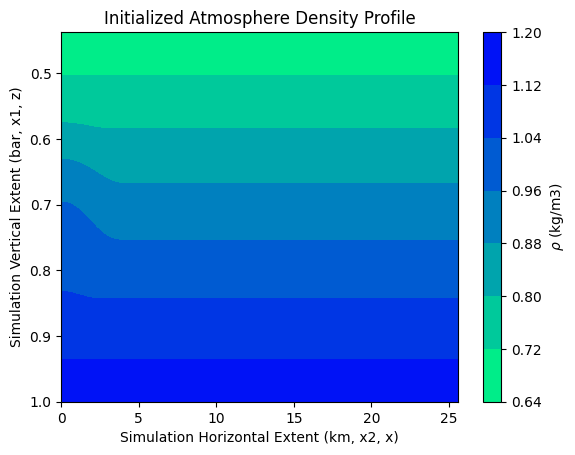

In [12]:
# Solve for air density
# Note that we use the full initialized temperature of the atmosphere
# with the bubble temperature anomaly: 

density = (P/(Rd*(T_array+delta_T)))

# Plot
plt.contourf(X/1000,P/1e5, density, cmap = 'winter_r',)
plt.gca().invert_yaxis()
plt.title(r'Initialized Atmosphere Density Profile')
plt.xlabel('Simulation Horizontal Extent (km, x2, x)')
plt.ylabel('Simulation Vertical Extent (bar, x1, z)')
plt.colorbar(label = r'$\rho$ (kg/m3)')

<div class="alert alert-block alert-success">

Great! So we have a good idea how our bubble and its surrounding atmosphere is set up before we let it drop. 

Now lets go to **Part 2**, where we discuss how to set up the `.yaml` file that is used as input to $\texttt{PADDLE}$.